In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import bps
from bps import generate_bps_ngrid
import torch
import numpy as np
import matplotlib.pyplot as plt
from scene_reconstruction_procedural import interpolate_distance_map, apply_threshold

In [2]:
environments = np.load('../environment_generation/environments/environments_64_12_1000_1.npy')
grid_list = [grid for grid in environments]

In [3]:
grid = grid_list[5]
basis = generate_bps_ngrid(32, 2, minv=0, maxv=63)
full, empty = bps.create_scene_point_cloud(grid, create_empty_cloud=True)

bps_encoding = bps.encode_scene(full, basis, "scalar", "none", empty, grid_shape_for_grid_basis=(32,32))

In [4]:
def reconstruct_from_bps(bps_grid, basis_pts, output_grid_length):
    H = output_grid_length
    W = output_grid_length
    img = np.ones((H, W), dtype=float)
    basis_pts = np.round(basis_pts)
    yy, xx = np.mgrid[0:H, 0:W]
    bps_vector = np.ravel(bps_grid)

    for (x, y), value in zip(basis_pts, bps_vector):
        radius = abs(value)
        dist = np.sqrt((xx - x)**2 + (yy - y)**2)

        if value < 0:
            img[dist <= radius] = 1
        else:
            img[dist <= radius] = 0

    return img

(32, 32)


Text(0.5, 1.0, 'Bilinear Interpolation')

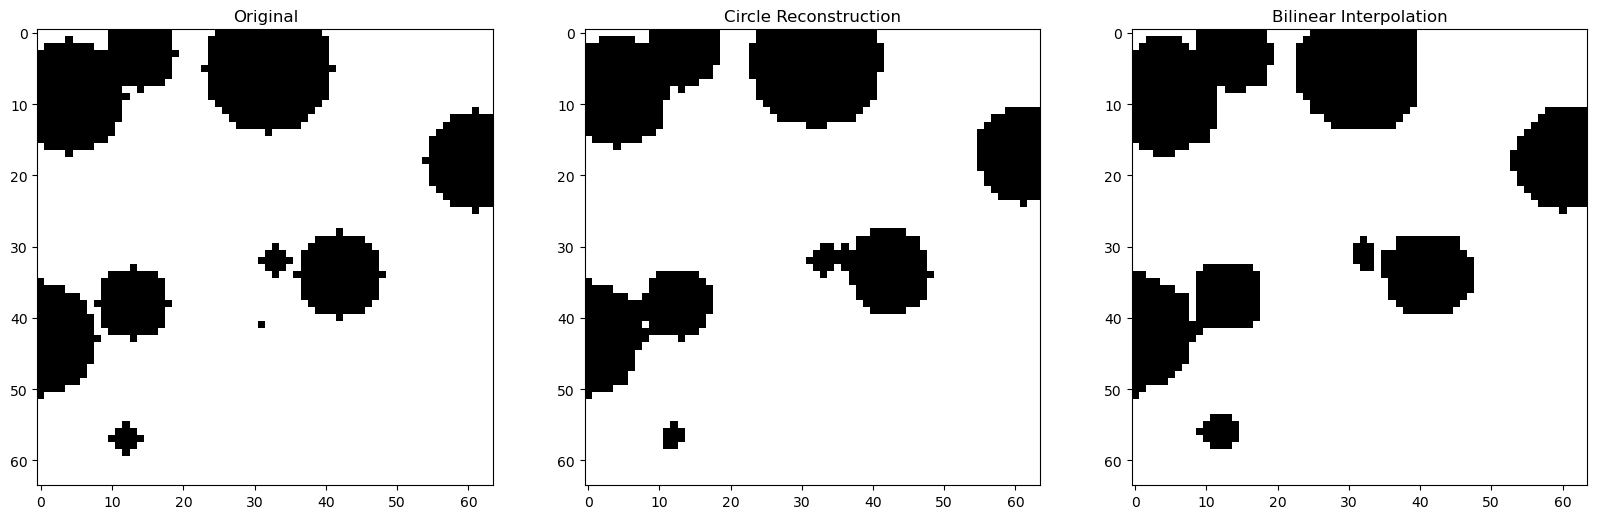

In [5]:
reconstruction = reconstruct_from_bps(bps_encoding, basis, 64)


print(bps_encoding.shape)
distance_map = interpolate_distance_map(bps_encoding, 32, 64)
predicted_grid= torch.from_numpy(apply_threshold(distance_map))

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(grid, cmap = 'binary')
axs[0].set_title('Original')
axs[1].imshow(reconstruction, cmap = 'binary')
axs[1].set_title('Circle Reconstruction')
axs[2].imshow(predicted_grid, cmap = 'binary')
axs[2].set_title('Bilinear Interpolation')

In [ ]:
n_bps = 32
environments = np.load('../environment_generation/environments/environments_64_15_1000_1.npy')
grid_list = [grid for grid in environments]


basis = generate_bps_ngrid(n_bps, 2, minv=0, maxv=63)

reconstruction_acc_sum = 0
prediction_acc_sum = 0
for grid in grid_list:
    
    full, empty = bps.create_scene_point_cloud(grid, create_empty_cloud=True)

    bps_encoding = bps.encode_scene(full, basis, "scalar", "none", empty, grid_shape_for_grid_basis=(n_bps,n_bps))

    reconstruction = reconstruct_from_bps(bps_encoding, basis, 64)

    distance_map = interpolate_distance_map(bps_encoding, n_bps, 64)
    predicted_grid= torch.from_numpy(apply_threshold(distance_map))

    reconstructin_acc = np.sum([reconstruction == grid])/64**2
    prediction_acc = np.sum([predicted_grid == grid])/64**2
    

    reconstruction_acc_sum += reconstructin_acc
    prediction_acc_sum += prediction_acc

print('Average Circle Reconstruction Accuracy: ', reconstruction_acc_sum/len(grid_list))
print('Average Bilinear Reconstruction Accuracy: ', prediction_acc_sum/len(grid_list))



Average Circle Reconstruction Loss:  0.969038818359375
Average Bilinear Reconstruction Loss:  0.949801513671875
